In [1]:
import pickle
import os
from glob import glob
import datetime
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
from model import analyse
import numpy as np
from scipy import stats

plt.style.use(style="ggplot")

# font size in the paper is 9
plt.rcParams.update({"font.size": 9})

# widths of figures in inches
TWO_COLUMN_FIG_WIDTH = 7.00697
SINGLE_COLUMN_FIG_WIDTH = 3.3374

# Experiment 6

Let's read in the files:

In [2]:
output_dir = "./experiments/experiment6/experiment6_output"
file_pattern = "experiment6_results_*.pickle"

results = []

for file_path in glob(os.path.join(output_dir, file_pattern)):
    with open(file_path, "rb") as f:
        run_results = pickle.load(f)
        results.append(run_results)

Let's check that we have all the results:

In [3]:
print(f"Experiment 6: {len(results)}")

Experiment 6: 128


In [4]:
ids = tuple(r["run_id"] for r in results)
for i in range(128):
    if i not in ids:
        print(i)

We've got all the data!

In [5]:
list(results[0].keys())

['run_id',
 'duration',
 'seed',
 'exploration_coef',
 'softargmax_coef',
 'reasoning_level',
 'action_dist_0',
 'params',
 'run_length',
 'agent_df',
 'lower_tree_query_data',
 'actions',
 'rewards',
 'action_qualities']

Show statistics about the durations of model evaluations:

In [6]:
subset = [res["duration"] for res in results]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 8:54:33.710207
Maximum: 22:29:35.562303


In [7]:
# average time for reasoning level 1 and random action_dist_0
subset = [
    res["duration"]
    for res in results
    if res["reasoning_level"] == 1 and res["action_dist_0"] == "random"
]
avg_duration = sum((d for d in subset), start=datetime.timedelta(0)) / len(subset)
print(f"Average: {avg_duration}")
print(f"Maximum: {max(subset)}")

Average: 19:47:54.953958
Maximum: 22:29:35.562303


Show a sample of model query statistics (a higher level model asking a lower level model for an action):

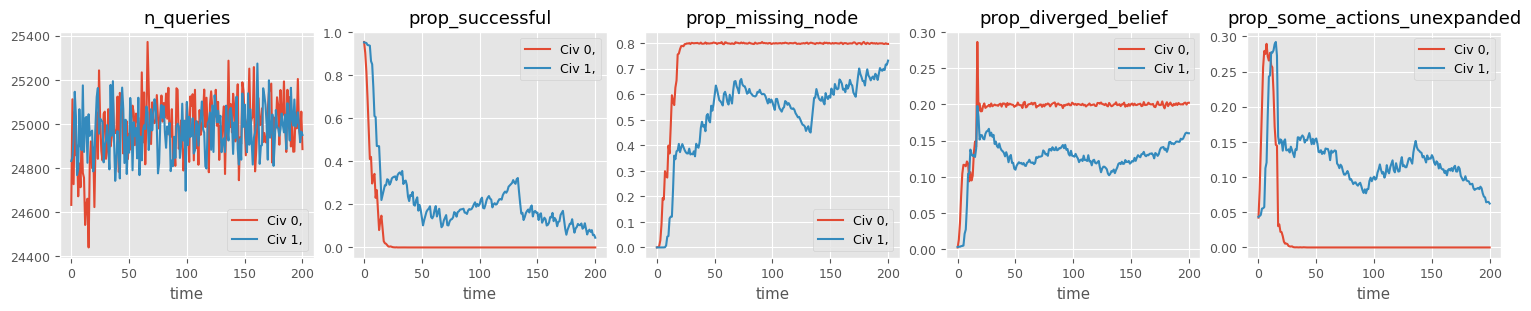

In [8]:
res = results[4]

# let's turn the results into a DataFrame
rows = []

for t, time_step_data in enumerate(res["lower_tree_query_data"]):
    for tree, values in time_step_data.items():
        # if there are no queries, skip
        if values[0] == 0:
            continue

        rows.append((t, tree, *values))

query_data = pd.DataFrame(
    rows,
    columns=(
        "time",
        "tree",
        "n_queries",
        "prop_successful",
        "prop_missing_node",
        "prop_diverged_belief",
        "prop_some_actions_unexpanded",
    ),
)

# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15, 3))

for i, column in enumerate(query_data.columns[2:]):
    for tree, tree_data in query_data.groupby("tree"):
        axs[i].plot("time", column, data=tree_data, label=tree)

    axs[i].set_title(column)
    axs[i].legend()
    axs[i].set_xlabel("time")

In [9]:
# check which runs didn't finish
n = 0
for r in results:
    if r["run_length"] < 100:
        print(
            f"{r['run_id']}: {r['run_length']}, {r['exploration_coef']:.2f}, {r['reasoning_level']}"
        )
        n += 1

print(f"Total: {n}")

1: 3, 0.30, 0
61: 16, 0.60, 0
73: 8, 0.60, 0
45: 1, 0.60, 0
57: 16, 0.60, 0
49: 6, 0.30, 0
47: 2, 0.60, 1
5: 3, 0.30, 0
9: 1, 0.60, 0
53: 6, 0.30, 0
41: 1, 0.60, 0
77: 8, 0.60, 0
69: 13, 0.30, 0
65: 13, 0.30, 0
39: 3, 0.30, 1
35: 3, 0.30, 1
81: 14, 0.30, 0
93: 19, 0.60, 0
29: 2, 0.60, 0
125: 1, 0.60, 0
37: 1, 0.30, 0
25: 2, 0.60, 0
101: 32, 0.30, 0
13: 1, 0.60, 0
113: 1, 0.30, 0
117: 1, 0.30, 0
109: 17, 0.60, 0
105: 17, 0.60, 0
17: 2, 0.30, 0
21: 2, 0.30, 0
121: 1, 0.60, 0
33: 1, 0.30, 0
97: 32, 0.30, 0
89: 19, 0.60, 0
85: 14, 0.30, 0
Total: 35


Interesting: in most divergence cases the reasoning level is 0.

Let's visualise the query success rates as averages over all runs over time.

In [10]:
# let's turn the results into a DataFrame
rows = []

# the simulations are level 1 (or 0, but these we ignore)
tree_levels = {"Civ 0,": 1, "Civ 1,": 1, "Civ 0, Civ 1": 0, "Civ 1, Civ 0": 0}

for run_result in results:
    if run_result["reasoning_level"] == 0:
        continue

    if run_result["run_length"] < 10:
        continue

    exploration_coef = run_result["exploration_coef"]

    for t, time_step_data in enumerate(run_result["lower_tree_query_data"]):
        for tree, values in time_step_data.items():
            # level of the tree
            tree_level = tree_levels[tree]

            # if there are no queries, skip
            if tree_level == 0:
                continue

            if values[0] == 0:
                print(run_result["run_id"], values, t, exploration_coef)

            rows.append((t, tree, exploration_coef, tree_level, *values))

query_data = pd.DataFrame(
    rows,
    columns=(
        "time",
        "tree",
        "exploration_coef",
        "level",
        "n_queries",
        "prop_successful",
        "prop_missing_node",
        "prop_diverged_belief",
        "prop_some_actions_unexpanded",
    ),
)

In [11]:
query_data

,time,tree,exploration_coef,level,n_queries,prop_successful,prop_missing_node,prop_diverged_belief,prop_some_actions_unexpanded
0,0,"Civ 0,",0.6,1,24633,0.955020,0.000081,0.002476,0.042423
1,0,"Civ 1,",0.6,1,24832,0.953165,0.000161,0.003181,0.043492
2,1,"Civ 0,",0.6,1,25112,0.904269,0.001234,0.013221,0.081276
3,1,"Civ 1,",0.6,1,24848,0.951827,0.000000,0.003542,0.044631
4,2,"Civ 0,",0.6,1,24727,0.816759,0.005015,0.036802,0.141424
...,...,...,...,...,...,...,...,...,...
24517,198,"Civ 1,",0.3,1,25060,0.000000,0.798364,0.201636,0.000000
24518,199,"Civ 0,",0.3,1,24912,0.369581,0.313704,0.006944,0.309770
24519,199,"Civ 1,",0.3,1,25075,0.000000,0.803031,0.196969,0.000000
24520,200,"Civ 0,",0.3,1,24938,0.405526,0.285909,0.003248,0.305317


Compare average results from the two exploration coefficient values tested:

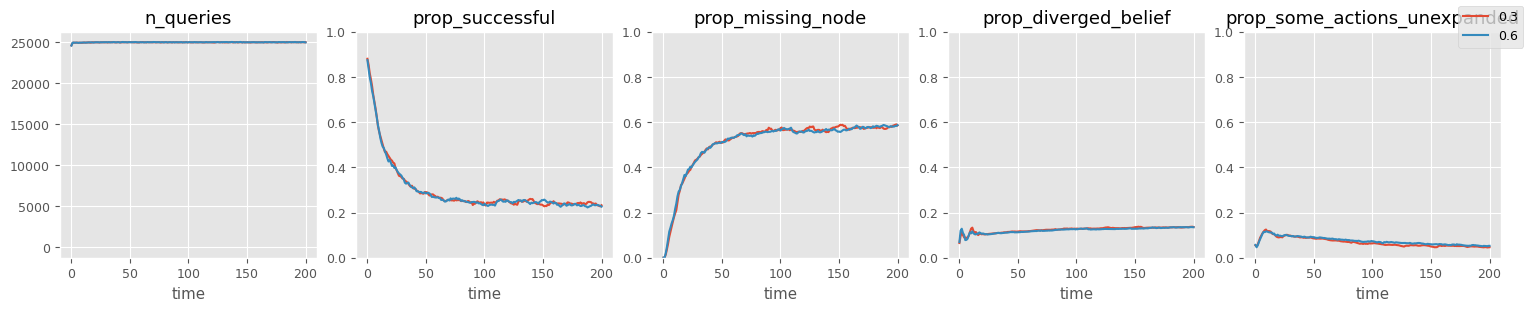

In [12]:
# plot

fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(15, 3))

metrics = [
    "n_queries",
    "prop_successful",
    "prop_missing_node",
    "prop_diverged_belief",
    "prop_some_actions_unexpanded",
]

for i, metric in enumerate(metrics):
    for group, group_data in query_data.groupby("exploration_coef"):
        avg_metric = group_data.groupby("time")[metric].mean()

        axs[i].plot(avg_metric.index, avg_metric, label=group if i == 0 else None)

    axs[i].set_title(metric)
    axs[i].set_xlabel("time")

    if metric != "n_queries":
        axs[i].set_ylim((0, 1))
    else:
        # add point 0 to data limits so scaling is correct
        axs[i].update_datalim([(0, 0)])

fig.legend()
plt.show()

And now all results together:

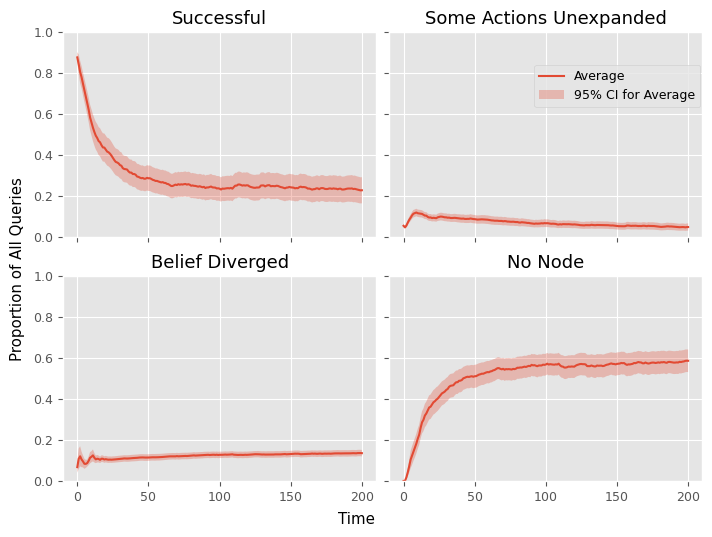

In [13]:
# plot
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    constrained_layout=True,
    figsize=(TWO_COLUMN_FIG_WIDTH, 0.75 * TWO_COLUMN_FIG_WIDTH),
    sharex=True,
    sharey=True,
)

ax_indices = {
    "prop_successful": (0, 0),
    "prop_missing_node": (1, 1),
    "prop_diverged_belief": (1, 0),
    "prop_some_actions_unexpanded": (0, 1),
}

pretty_titles = {
    "prop_successful": "Successful",
    "prop_missing_node": "No Node",
    "prop_diverged_belief": "Belief Diverged",
    "prop_some_actions_unexpanded": "Some Actions Unexpanded",
}

for metric in ax_indices.keys():
    ax = axs[*ax_indices[metric]]

    for level, level_data in query_data.groupby("level"):
        avg_metric = level_data.groupby("time")[metric].mean()
        avg_metric_error_margin = level_data.groupby("time")[metric].aggregate(
            lambda x: analyse.t_confidence_interval(x)[1]
        )

        ax.plot(avg_metric.index, avg_metric, label="Average")
        ax.fill_between(
            avg_metric.index,
            avg_metric + avg_metric_error_margin,
            avg_metric - avg_metric_error_margin,
            alpha=0.3,
            label="95% CI for Average",
        )

    ax.set_title(pretty_titles[metric])
    # ax.legend()

    if metric != "n_queries":
        ax.set_ylim((0, 1))
    else:
        # add point 0 to data limits so scaling is correct
        ax.update_datalim([(0, 0)])

fig.supxlabel("Time")
fig.supylabel("Proportion of All Queries")

handles, labels = fig.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(unique_labels.values(), unique_labels.keys(), loc=(0.75, 0.8))

# plt.savefig("paper/lower_tree_queries.pdf")
plt.show()

Let's turn our attention to the main attraction -- the attack and peace streak distributions:

In [14]:
attack_streak_rows = []
peace_streak_rows = []

raw_attack_streak_data = []
raw_peace_streak_data = []

for run_result in results:
    run_id = run_result["run_id"]
    run_length = run_result["run_length"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coef"]
    reasoning_level = run_result["reasoning_level"]
    action_dist_0 = run_result["action_dist_0"]

    # exclude runs that were less than 80 time steps (an arbitrary number)
    if run_length < 80:
        continue

    if action_dist_0 == "passive":
        continue

    if exploration_coef != 0.6:
        continue

    if softargmax_coef != 0.1:
        continue

    print(f"Length {run_length}, reasoning level {reasoning_level}")

    run_action_data = run_result["actions"]

    # analyse streaks
    run_attack_streaks = analyse.count_attack_streaks(run_action_data)
    run_peace_streaks = analyse.count_peace_streaks(run_action_data)

    # add individual streaks to raw data
    raw_attack_streak_data.extend(
        (
            streak_length
            for streak_length in run_attack_streaks
            for _ in range(run_attack_streaks[streak_length])
        )
    )
    raw_peace_streak_data.extend(
        (
            streak_length
            for streak_length in run_peace_streaks
            for _ in range(run_peace_streaks[streak_length])
        )
    )

Length 201, reasoning level 1
Length 201, reasoning level 1
Length 201, reasoning level 0
Length 201, reasoning level 1
Length 201, reasoning level 0
Length 201, reasoning level 0
Length 201, reasoning level 0
Length 201, reasoning level 1
Length 201, reasoning level 1
Length 201, reasoning level 0
Length 201, reasoning level 0
Length 201, reasoning level 1
Length 201, reasoning level 1
Length 201, reasoning level 1
Length 201, reasoning level 0
Length 201, reasoning level 0


Plot results:

  params: FitParams(p=0.7648546093573799, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(p=0.2537011809936398, loc=0.0)
 success: True
 message: 'Optimization terminated successfully.'


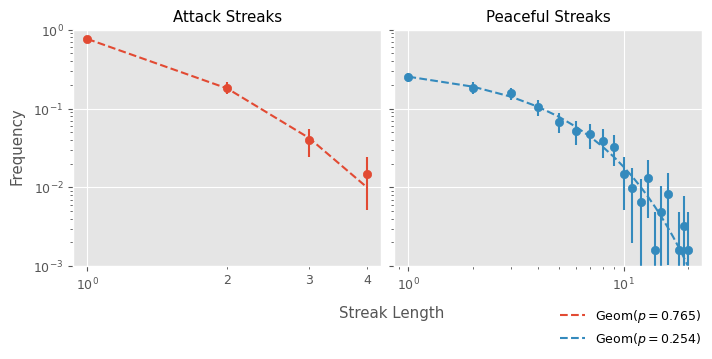

In [15]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(TWO_COLUMN_FIG_WIDTH, 3.5),
    constrained_layout=True,
    sharey=True,
)

data_titles = {0: "Attack Streaks", 1: "Peaceful Streaks"}

for i, data in enumerate((raw_attack_streak_data, raw_peace_streak_data)):
    n_streaks = len(data)

    color = f"C{i}"

    # count frequencies
    counts = pd.Series(data).value_counts(normalize=True)

    # calculate uncertainty: a simple confidence interval for the proportion of
    # time we randomly choose a random value from the population
    error_margins = 1.96 * np.sqrt(counts * (1 - counts) / n_streaks)

    # plot
    axs[i].scatter(x=counts.index, y=counts, color=color, marker="o")
    axs[i].errorbar(
        x=counts.index, y=counts, yerr=error_margins, color=color, fmt="none"
    )

    if i == 0:
        fit = stats.fit(stats.geom, data=data, bounds={"p": (0, 1)})
        print(fit)
        k = np.arange(1, max(data) + 1)
        y = stats.geom.pmf(k=k, p=fit.params.p)
        axs[i].plot(
            k,
            y,
            color=color,
            linestyle="dashed",
            label=rf"Geom$(p={fit.params.p:.3f})$",
        )
    elif i == 1:
        fit = stats.fit(stats.geom, data=data, bounds={"p": (0, 1)})
        print(fit)
        k = np.arange(1, max(data) + 1)
        y = stats.geom.pmf(k=k, p=fit.params.p)
        axs[i].plot(
            k,
            y,
            color=color,
            linestyle="dashed",
            label=rf"Geom$(p={fit.params.p:.3f})$",
        )

    axs[i].set_yscale("log")
    axs[i].set_xscale("log")
    axs[i].set_title(data_titles[i], fontsize="large")

    axs[i].set_ylim((1e-3, 1))

    if i == 0:
        formatter = ticker.FormatStrFormatter("%g")
        axs[i].xaxis.set_minor_formatter(formatter)

fig.supxlabel("Streak Length", y=0.10, x=0.55, color=plt.rcParams["xtick.color"])
fig.supylabel("Frequency", y=0.6, color=plt.rcParams["xtick.color"])
fig.legend(loc="outside lower right", frameon=False)

# plt.savefig("paper/experiment6.pdf")
plt.show()

## Other Data Exploration

Let's construct a dataset of attack magnitudes:

In [16]:
magnitudes = []

for run_result in results:
    run_id = run_result["run_id"]
    run_length = run_result["run_length"]
    exploration_coef = run_result["exploration_coef"]
    softargmax_coef = run_result["softargmax_coef"]
    reasoning_level = run_result["reasoning_level"]
    action_dist_0 = run_result["action_dist_0"]

    run_action_data = run_result["actions"]
    run_agent_data = run_result["agent_df"]

    for t in run_action_data["time"][:-1]:
        # check if action at time t was a successful attack
        time_action_data = run_action_data[run_action_data["time"] == t]

        if not (
            (time_action_data.loc[t, "action"] == "a")
            and (time_action_data.loc[t, "attack_successful"] == True)
        ):
            continue

        target = int(time_action_data.loc[t, "attack_target"])

        # calculate the magnitude of loss of technology level in the recipient of the attack
        magnitude = (
            run_agent_data.xs(key=t, axis=0, level="Step").loc[target, "Technology"]
            - run_agent_data.xs(key=t + 1, axis=0, level="Step").loc[
                target, "Technology"
            ]
        )

        # store
        magnitudes.append(magnitude)

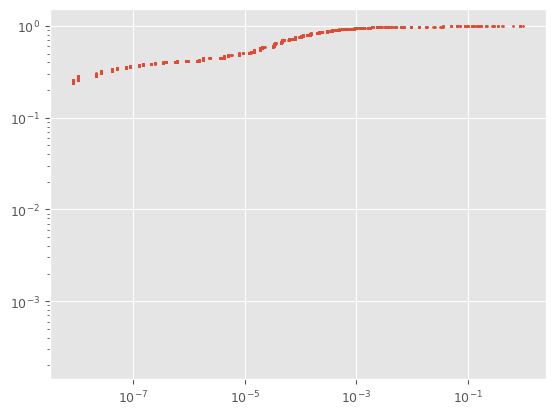

In [17]:
fig, ax = plt.subplots()

# we will plot the survival function

# sort magnitudes
magnitudes.sort()

subset = [m for m in magnitudes]  # if m > 1e-3]

# cumulative proportions
cumulative = np.arange(start=1, stop=len(subset) + 1) / len(subset)

# plot
ax.scatter(subset, cumulative, s=2)
ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

In [18]:
min(magnitudes)

0.0

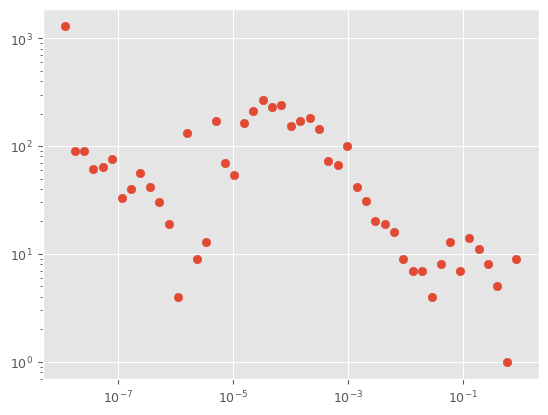

In [19]:
fig, ax = plt.subplots()

bins = np.logspace(-8, 0, 50)
bin_mids = np.logspace(-8, 0, 99)[1::2]


bin_freqs = np.zeros(len(bins) - 1)

for m in magnitudes:
    for i, bin_upper_bound in enumerate(bins[1:]):
        if m < bin_upper_bound:
            bin_freqs[i] += 1
            break
    else:
        assert False

ax.scatter(bin_mids, bin_freqs)
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

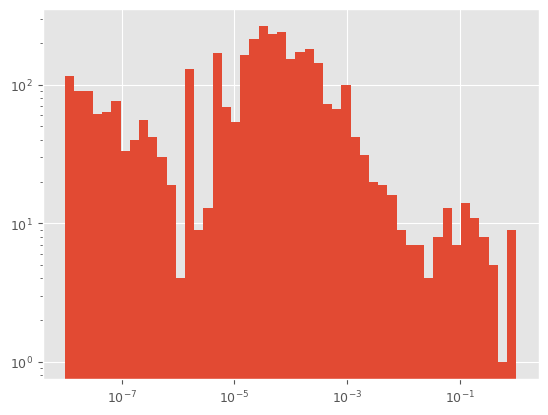

In [20]:
fig, ax = plt.subplots()

ax.hist(magnitudes, bins=bins)

ax.set_xscale("log")
ax.set_yscale("log")
plt.show()